# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("../data/lfw/*/*"))
dog_files = np.array(glob("../data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8617 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


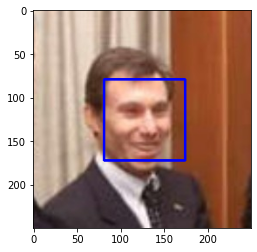

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)
* Percentage of first 100 images in human_files that detected a human face: 99%
* Percentage of first 100 images of dog_files that detected a human face: 18%

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
true_humans = 0
i=1
print_every = 50
for path in human_files_short:
    if i%print_every==0:
        print("{}% of human files processed".format(i/len(human_files_short)*100))
    i+=1
    if(face_detector(path)):
        true_humans +=1
i=1
false_humans = 0
for path2 in dog_files_short:
    if i%print_every==0:
        print("{}% of human files processed".format(i/len(dog_files_short)*100))
    i+=1
    if(face_detector(path2)):
        false_humans +=1
        
print(f'Percentage of humans detected in human_files_short: {true_humans/len(human_files_short)*100}%')
print(f'Percentage of humans in dog_files_short: {false_humans/len(dog_files_short)*100}%')

50.0% of human files processed
100.0% of human files processed
50.0% of human files processed
100.0% of human files processed
Percentage of humans detected in human_files_short: 99.0%
Percentage of humans in dog_files_short: 18.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

**Note:** I did not use a custom algorithm, I kept using OpenCV

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Display the device on which the model is running (CPU / GPU)

In [6]:
next(VGG16.parameters()).device

device(type='cpu')

Display the architecture of the VGG16 model

In [7]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:
from PIL import Image
import torchvision.transforms as transforms
#import torchvision.datasets as datasets
Image.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    im = Image.open(img_path)
    
    data_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
            
    img_data = data_transform(im).unsqueeze_(0)
    
    if use_cuda:
        img_data = img_data.to('cuda')
                                 
    prediction = VGG16(img_data)
    
    value, index = prediction[0].max(0)
    return index.item()
#    return VGG16(img_data)
#    return None # predicted class index

Build a dictionary of the classes in "ImageNet" used by the VGG-16 model

In [9]:
with open("ImageNet_mapping.txt") as f:
    vgg16_index_to_name = eval(f.read())

Building a dictionary with the results of the predictions by the VGG-16 model

In [10]:
results_list = []
index = 0
for img in human_files_short:
    prediction = VGG16_predict(img)
    result = {
    'prediction_index': prediction,
    'prediction_name': vgg16_index_to_name[prediction],
    'file_name':img,
    'file_index:':index
    }
    results_list.append(result)
    index +=1

#### Visualizing some of the predictions made and the actual pictures

Prediction Index: 400 Prediction Name: academic gown, academic robe, judge's robe File Name: ../data/lfw/Jimmy_Iovine/Jimmy_Iovine_0001.jpg


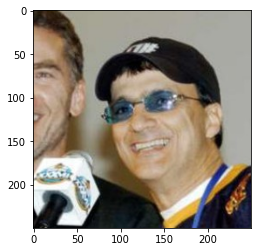

Prediction Index: 715 Prediction Name: pickelhaube File Name: ../data/lfw/Claudia_Pechstein/Claudia_Pechstein_0001.jpg


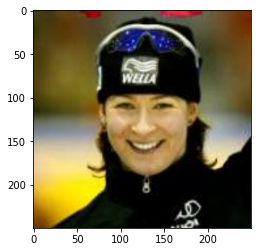

Prediction Index: 450 Prediction Name: bobsled, bobsleigh, bob File Name: ../data/lfw/Claudia_Pechstein/Claudia_Pechstein_0003.jpg


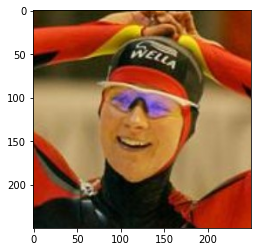

Prediction Index: 981 Prediction Name: ballplayer, baseball player File Name: ../data/lfw/Claudia_Pechstein/Claudia_Pechstein_0002.jpg


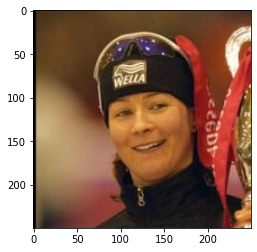

Prediction Index: 439 Prediction Name: bearskin, busby, shako File Name: ../data/lfw/Claudia_Pechstein/Claudia_Pechstein_0005.jpg


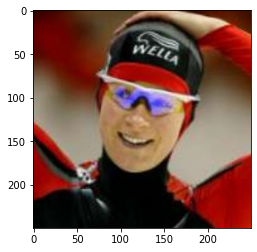

Prediction Index: 652 Prediction Name: military uniform File Name: ../data/lfw/Claudia_Pechstein/Claudia_Pechstein_0004.jpg


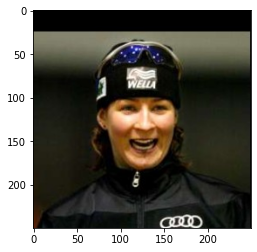

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0002.jpg


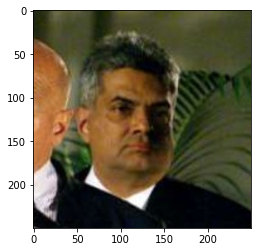

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0003.jpg


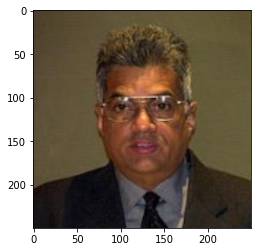

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/Ranil_Wickremasinghe/Ranil_Wickremasinghe_0001.jpg


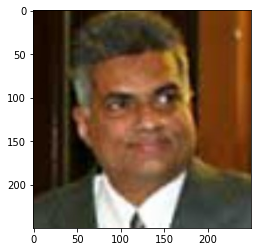

Prediction Index: 683 Prediction Name: oboe, hautboy, hautbois File Name: ../data/lfw/Ben_Chandler/Ben_Chandler_0001.jpg


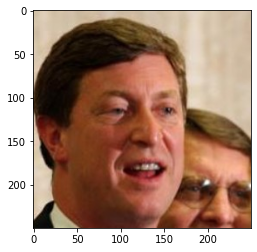

Prediction Index: 395 Prediction Name: gar, garfish, garpike, billfish, Lepisosteus osseus File Name: ../data/lfw/Mark_Komara/Mark_Komara_0001.jpg


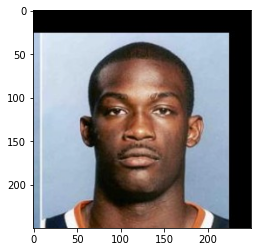

Prediction Index: 457 Prediction Name: bow tie, bow-tie, bowtie File Name: ../data/lfw/Rand_Beers/Rand_Beers_0001.jpg


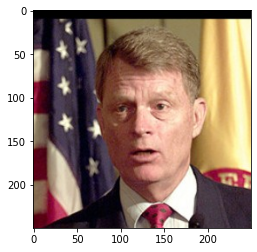

Prediction Index: 641 Prediction Name: maraca File Name: ../data/lfw/Joanne_Woodward/Joanne_Woodward_0001.jpg


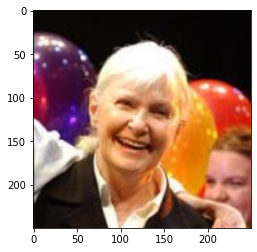

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/John_Bond/John_Bond_0001.jpg


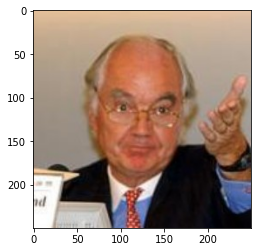

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/Reginald_Hudlin/Reginald_Hudlin_0001.jpg


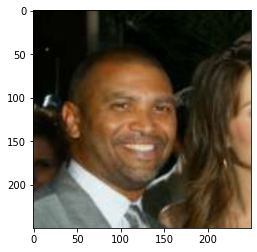

Prediction Index: 906 Prediction Name: Windsor tie File Name: ../data/lfw/Lee_Baca/Lee_Baca_0001.jpg


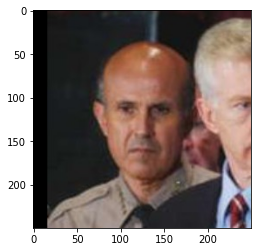

Prediction Index: 903 Prediction Name: wig File Name: ../data/lfw/Mary-Kate_Olsen/Mary-Kate_Olsen_0002.jpg


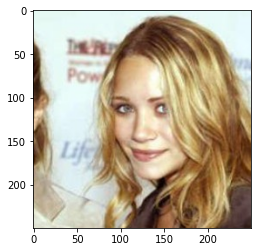

Prediction Index: 459 Prediction Name: brassiere, bra, bandeau File Name: ../data/lfw/Mary-Kate_Olsen/Mary-Kate_Olsen_0003.jpg


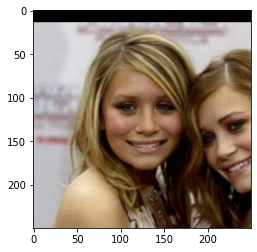

Prediction Index: 678 Prediction Name: neck brace File Name: ../data/lfw/Mary-Kate_Olsen/Mary-Kate_Olsen_0001.jpg


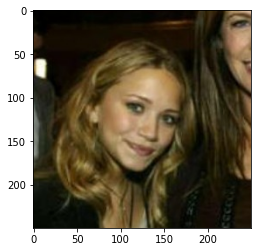

Prediction Index: 739 Prediction Name: potter's wheel File Name: ../data/lfw/Emily_Stevens/Emily_Stevens_0001.jpg


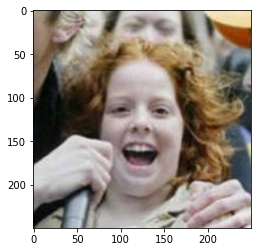

In [11]:
for i in range(10,30):
    item = results_list[i]
    print(f'Prediction Index: {item["prediction_index"]} Prediction Name: {item["prediction_name"]} File Name: {item["file_name"]}')
    plt.imshow(cv2.cvtColor(cv2.imread(item['file_name']), cv2.COLOR_BGR2RGB))
    plt.show()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    index = VGG16_predict(img_path)
    
    return 151 <= index <= 268 # true/false

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
true_dogs = 0
i=0
for path in dog_files_short:
    if (i%10==0):
        print(f'{i}%')
    i+=1
    if(dog_detector(path)):
        true_dogs +=1
i=0
false_dogs = 0
for path2 in human_files_short:
    if(i%10==0):
        print(f'{i}%')
    i+=1
    if(dog_detector(path2)):
        false_dogs +=1

print(f'Percentage of dogs in human_files_short: {false_dogs/len(human_files_short)*100}%')
print(f'Percentage of dogs detected in dog_files_short: {true_dogs/len(dog_files_short)*100}%')

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Percentage of dogs in human_files_short: 0.0%
Percentage of dogs detected in dog_files_short: 97.0%


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ <br>
* dog detected in human_files_short: 0%
* dogs detected in dog_files_short: 97% 


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

**Note:** I did not try using a different algorithm, I kept using VGG-16 to detect dog images

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
import torchvision.transforms as transforms
import torch
import torchvision.models as models

In [16]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
## In the data loaders below, I used the "data_reduced" directories, which contain a subset of the full dataset provided in this notebook
## The reason for this is that I will train the models using sagemaker, but I still want to verify locally that the model can be trained and
## that the training loss decreases. Therefore I try this with a reduced data set, while performing the real training using Sagemaker.
train_dir = '../data_reduced/dog_images/train'
valid_dir = '../data_reduced/dog_images/valid'
test_dir = '../data_reduced/dog_images/test'
test_full_dir = '../data/dog_images/test'

# Defining transforms for the training, validation, and testing sets

#The train transform will be randomly rotated and flipped in order to enhance the dataset by providing
#different variations of the pictures in the datasets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

#Using datasets.ImageFolder to load the data and apply the transforms to each dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_validation_transforms)
test_full_data = datasets.ImageFolder(test_full_dir, transform=test_validation_transforms)

#Creating dataloaders for each dataset
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(test_data, batch_size=64)
testFullLoader = torch.utils.data.DataLoader(test_full_data, batch_size=64)


#I used "short" loaders for the datasets trained locally, to try out the training script and have a broad idea about the 
#model I would eventually train. However "test_full" loader is the actual full test data set, since I use this later
#with the model trained using sagemaker to test the accuracy and other metrics
loaders={
    'train':trainloader,
    'test':testloader,
    'valid':validloader,
    'test_full':testFullLoader,
}

Creating a dictionary with the names of each of the dog breeds, from the names in the directories in the "full test"  dataset. The training and validation datasets also have the same categories, but I used "test_full_dir" since I used reduced data sets for the local training, and then the full datasets when training using sagemaker.

In [17]:
dog_category_dict = {}

for directory in os.listdir(test_full_dir):
    key, value = directory.split('.')
    if (key is not None and key !=""):
        dog_category_dict[int(key)-1]=value

In [18]:
len(dog_category_dict)

133

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:<br>
* The images were resized to 224 x 224. I chose this size of the tensor since I'll use a pre-trained VGG-16 model at a later stage in this notebook, and this model uses this shape for the inputs.<br>

* For the dataset, I decided to augment it by randomly rotating and flipping the images in the train dataset, in order to provide different positions of the pictures and augment the dataset in this way. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

**Note:** The model below matches the model that will be trained using sage maker (included in "train/model.py")

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class convClassifier(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(convClassifier, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,32,kernel_size=5)
        self.conv2 = nn.Conv2d(32,64,kernel_size=5)
        self.conv3 = nn.Conv2d(64,128,kernel_size=5)
        self.mp = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(73728,1000)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1000,133)

    def forward(self, x):
        ## Define forward behavior
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = F.relu(self.mp(self.conv3(x)))

        x = x.view(in_size,-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = convClassifier()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

To get the final CNN architecture I performed multiple tries with different layer configurations. In general the idea I used was to have a set of convolutional layers to extract features and then a fully connected layer at the end to perform the classification. I also used pooling layers to down sample the features detected on the convolutional part of model. I didn't use padding or stride. 

The steps I used to get the final architecture were the following:
1. Attempt to build a model using a simple architecture -> This gives me a starting point and a model to compare performance
2. Train the model with the full data set -> The model needs to be trained to make significant predictions
3. Measure performance metrics (accuracy in this case) -> So that we can measure the performance of the model
4. In case the accuracy is not higher than 10% (as required) adjust the hyperparameters (I mainly played with the number of epochs and learning rate) > I do this first, in case the accuracy is not reached due to insufficient training.
5. If the accuracy is still not high enough after a few tries, adjust the model architecture. -> As a final step, in case adjusting the training parameters does not improve the performance, then I adjust the model too. 

Initially I tried using the following simple architecture:

    * conv_layer1: conv2d(3,32, kernel_size=5) -> MaxPool(2) -> Relu
    * conv_layer2: conv2d(32, 64, kernel_size=5) -> MaxPool(2) -> Relu
    * Fully connected layer: linear -> log_softmax

With this configuration, initially I tried using 10 epochs, but the accuracy was not higher than the 10% required. I managed to reach an accuracy of 11.36% using 20 epochs and a learning rate of 0.01. Although the accuracy was higher than 10% I decided to try another configuration. 

Then I tried adding more convolutional layers and also additional relu -> dropout -> linear layers to the fully connected part of the model. 

**Final Configuration:** <br>
     * conv_layer1: conv2d(3,32,kernel_size=5) -> MaxPool(2) -> Relu  
     * conv_layer2: conv2d(32,64,kernel_size=5) -> MaxPool(2) -> Relu 
     * conv_layer3: conv2d(64,128,kernel_size=5) -> MaxPool(2) -> Relu
     * Fully connected layer: linear -> Relu -> Dropout -> linear -> log_softmax

When training this configuration, I used 40 epochs, and also I used a scheduler to update the learning rate (starting value 0.05) and decrease it by half each time 2 consecutive epochs did not reduce the training loss. 
    
With this final configuration, I reached an accuracy of 16.87% (as can be seen in the sections below and in the files under the "/train" directory used to train the model in SageMaker).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [31]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.02)

### I also used a scheduler to adjust the learning rate when the training loss is not reduced within 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, patience=2, factor=0.5, verbose=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [32]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print_every = 100
    steps = 0
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            try:
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## find the loss and update the model parameters accordingly
                #data.resize_(data.size()[0], 3*224*224)
                optimizer.zero_grad()

                output = model.forward(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                ## record the average training loss, using something like
                #train_loss += loss.item()
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                if steps % print_every == 0:
                    print("Epoch: {}/{}... ".format(epoch, n_epochs),
                          "Loss: {:.4f}".format(train_loss/print_every))
            except OSError as err:
                print("there was an error in batch: {}".format(batch_idx))
                print(err)
    
        
        ######################    
        # validate the model #
        ######################

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output_valid = model.forward(data)        
            v_loss = criterion(output_valid, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (v_loss.data - valid_loss))       
        
        scheduler.step(train_loss)
        ## TODO: save the model if validation loss has decreased        
        if valid_loss < valid_loss_min:
            path = os.path.join("model_dir", 'model.pth')
            print("Saving the model to: {}".format(path))
            print("Previous valid loss: {}, new valid loss:{}".format(valid_loss_min, valid_loss))
            torch.save(model.cpu().state_dict(), path)
            valid_loss_min = valid_loss
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
    
    return model
        
    # return trained model


Training the model from scratch. On the local training script, I used a reduced subset of the training, validation and test datasets, since I wanted to explore different ways of building the model (e.g. different architectures, using a scheduler, etc.). However I will train the real model using sagemaker (on the sections below) so that I can use a GPU and make the training faster.

In [33]:
# train the model
model_scratch = train(10, loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1/10...  Loss: 0.0488
Epoch: 1/10...  Loss: 0.0482
Epoch: 1/10...  Loss: 0.0471
Epoch: 1/10...  Loss: 0.0449
Epoch: 1/10...  Loss: 0.0417
Epoch: 1/10...  Loss: 0.0406
Epoch: 1/10...  Loss: 0.0400
Epoch: 1/10...  Loss: 0.0392
Saving the model to: model_dir/model.pth
Previous valid loss: inf, new valid loss:3.2266054153442383
Epoch: 1 	Training Loss: 3.922899 	Validation Loss: 3.226605
Epoch: 2/10...  Loss: 0.0344
Epoch: 2/10...  Loss: 0.0346
Epoch: 2/10...  Loss: 0.0357
Epoch: 2/10...  Loss: 0.0339
Epoch: 2/10...  Loss: 0.0334
Epoch: 2/10...  Loss: 0.0329
Epoch: 2/10...  Loss: 0.0327
Epoch: 2/10...  Loss: 0.0316
Saving the model to: model_dir/model.pth
Previous valid loss: 3.2266054153442383, new valid loss:2.3495585918426514
Epoch: 2 	Training Loss: 3.159841 	Validation Loss: 2.349559
Epoch: 3/10...  Loss: 0.0240
Epoch: 3/10...  Loss: 0.0237
Epoch: 3/10...  Loss: 0.0240
Epoch: 3/10...  Loss: 0.0240
Epoch: 3/10...  Loss: 0.0236
Epoch: 3/10...  Loss: 0.0235
Epoch: 3/10...  Loss: 0

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [34]:
model_scratch_load = convClassifier()

In [35]:
load_path = os.path.join("model_dir", 'model.pth')
model_scratch_load.load_state_dict(torch.load(load_path))
model_scratch_load.eval()

convClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=1000, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=133, bias=True)
)

In [36]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [37]:
# call test function    
test(loaders, model_scratch_load, criterion_scratch, use_cuda)

Test Loss: 1.791040


Test Accuracy: 38% (24/63)


**Note:** The accuracy achieved above is just on the reduced data set used for the local training of the model (without GPU) the real accuracy metrics will be shown in the next section, where the model is trained using sagemaker and the full dataset.

## Step 3 - Part 2 - Training Model using Amazon Sage Maker

On the previous step, the model from scratch was trained using 1 epoch, since it's being trained in my local machine which doesn't have a GPU, for the real training with more epochs, we will use the Sagemaker API, so that we can use a GPU while training and therefore reduce the training time. 

In [38]:
import sagemaker
import boto3
import os
from dotenv import load_dotenv
load_dotenv()

sagemaker_session = sagemaker.Session()

bucket_name = os.getenv('s3_bucket_name')
bucket = boto3.resource('s3').Bucket(bucket_name)

prefix = 'data/dog_images'

role = os.getenv('AWS_IAM_Role_name')

input_data = os.path.join('s3://',bucket.name,prefix)

In [43]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train_scratch.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 40,
                    })

In [44]:
estimator.fit({'training': input_data})

2020-08-04 09:14:18 Starting - Starting the training job...
2020-08-04 09:14:20 Starting - Launching requested ML instances......
2020-08-04 09:15:23 Starting - Preparing the instances for training............
2020-08-04 09:17:27 Downloading - Downloading input data.........
2020-08-04 09:19:16 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-04 09:19:17,804 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-04 09:19:17,828 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-04 09:19:18,447 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-04 09:19:18,752 sagemaker-containers INFO     Module train_scratch does not provide a setup.py. 
Generating setup.py
2020-08-04 09:19:18,752 sagemaker-containers INFO     Generating setup.cfg
2

Epoch: 14 #011 Training Loss: 4.291023 #011 Validation Loss: 4.211626
Saving the model.
Epoch: 15 #011 Training Loss: 4.254220 #011 Validation Loss: 4.109172
Saving the model.
Epoch: 16 #011 Training Loss: 4.221295 #011 Validation Loss: 4.022227
Validation loss improved in epoch: 16, Previous valid loss: 4.107555866241455, new valid loss:4.022226810455322
Saving the model.
Epoch: 17 #011 Training Loss: 4.186284 #011 Validation Loss: 4.390318
Saving the model.
Epoch: 18 #011 Training Loss: 4.164100 #011 Validation Loss: 4.080857
Saving the model.
Epoch: 19 #011 Training Loss: 4.103484 #011 Validation Loss: 4.240841
Saving the model.
Epoch: 20 #011 Training Loss: 4.114130 #011 Validation Loss: 4.466499
Saving the model.
Epoch: 21 #011 Training Loss: 4.445423 #011 Validation Loss: 3.907797
Validation loss improved in epoch: 21, Previous valid loss: 4.022226810455322, new valid loss:3.90779709815979
Saving the model.
Epoch    21: reducing learning rate of group 0 to 2.5000e-02.
Epoch: 22 #

In [45]:
estimator.model_data

's3://sagemaker-eu-central-1-262088320481/sagemaker-pytorch-2020-08-04-09-14-17-329/output/model.tar.gz'

### Testing Model Accuracy

Deploy the predictor for use with the Sagemaker API (not with the web app)

In [46]:
pytorch_predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

In [47]:
pytorch_predictor

In [48]:
def test_sagemaker_model(loaders, model, use_cuda):

    # monitor test loss and accuracy
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test_full']):
        #print(batch_idx)
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        for i in range(0,len(data)):
            test_single_input = data[i].unsqueeze(0)
            test_single_target = target[i]
            test_single_output = pytorch_predictor.predict(test_single_input)
            total += 1
            if(test_single_output.argmax() == int(test_single_target)):
                correct +=1
            
    print("Total correct predictions {}:".format(correct))
    print("Total all images: {}".format(total))
    print("Accuracy: {}%".format(round(correct/total*100,2)))




In [49]:
test_sagemaker_model(loaders, pytorch_predictor, use_cuda)

Total correct predictions 141.0:
Total all images: 836.0
Accuracy: 16.87%


In [50]:
pytorch_predictor.delete_endpoint()

### ---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

#### Note:
For this the pre-trained model I'm using the same loaders as for the model built from scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [51]:
import torch
import torch.nn as nn
from collections import OrderedDict

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for parameter in model_transfer.parameters():
    parameter.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([('fc1',nn.Linear(25088,5000)),
                                        ('relu',nn.ReLU()),
                                        ('drop',nn.Dropout(p=0.5)),
                                        ('fc2',nn.Linear(5000,133)),
                                        ('output',nn.LogSoftmax(dim=1))   
                                        ]))

model_transfer.classifier = classifier

In [52]:
device_transfer = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfer = model_transfer.to(device_transfer)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
For the pre-trained model, I used VGG-16 as the pre-trained part, since it is a suitable pretrained model, which was also used earlier in this notebook. Then I replaced the fully connected layers with a simple 2 layer network with dropout. I used ReLUs since this activation function has had better results than other activation functions (e.g. sigmoid or htan) in recent times. Then, I used a LogSoftmax function as output, since there are many classes being classified


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [53]:
import torch.optim as optim

### TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.01)

### I also used a scheduler to adjust the learning rate when the training loss is not reduced within 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, patience=2, factor=0.5, verbose=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Here again, I use a reduced data set on the training script, since I'm running it locally. The real training using the full data set will be executed using Sagemaker to use a GPU.

In [54]:
# train the model

model_transfer = train(5, loaders, model_transfer, optimizer_transfer, criterion_transfer, False, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1/5...  Loss: 0.0499
Epoch: 1/5...  Loss: 0.0411
Epoch: 1/5...  Loss: 0.0354
Epoch: 1/5...  Loss: 0.0320
Epoch: 1/5...  Loss: 0.0300
Epoch: 1/5...  Loss: 0.0268
Epoch: 1/5...  Loss: 0.0244
Epoch: 1/5...  Loss: 0.0226
Saving the model to: model_dir/model.pth
Previous valid loss: inf, new valid loss:0.35853737592697144
Epoch: 1 	Training Loss: 2.260299 	Validation Loss: 0.358537
Epoch: 2/5...  Loss: 0.0109
Epoch: 2/5...  Loss: 0.0088
Epoch: 2/5...  Loss: 0.0086
Epoch: 2/5...  Loss: 0.0079
Epoch: 2/5...  Loss: 0.0081
Epoch: 2/5...  Loss: 0.0078
Epoch: 2/5...  Loss: 0.0077
Epoch: 2/5...  Loss: 0.0075
Saving the model to: model_dir/model.pth
Previous valid loss: 0.35853737592697144, new valid loss:0.20151211321353912
Epoch: 2 	Training Loss: 0.754172 	Validation Loss: 0.201512
Epoch: 3/5...  Loss: 0.0068
Epoch: 3/5...  Loss: 0.0064
Epoch: 3/5...  Loss: 0.0063
Epoch: 3/5...  Loss: 0.0058
Epoch: 3/5...  Loss: 0.0056
Epoch: 3/5...  Loss: 0.0054
Epoch: 3/5...  Loss: 0.0053
Epoch: 3/5... 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [55]:
#test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)
test(loaders, model_transfer, criterion_transfer, False)

Test Loss: 0.123961


Test Accuracy: 95% (60/63)


In the reduced data set, the accuracy achieved using the pre-trained model is 95%. Although this is quite a high, this is not yet in the full dataset. The accuracy for the full dataset will be calculated below with the model trained using Sagemaker.

### Train Transfer Learning Model with Sagemaker

In [90]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 25,
                    })

In [91]:
estimator.fit({'training': input_data})

2020-08-04 21:10:03 Starting - Starting the training job...
2020-08-04 21:10:06 Starting - Launching requested ML instances......
2020-08-04 21:11:10 Starting - Preparing the instances for training......
2020-08-04 21:12:25 Downloading - Downloading input data............
2020-08-04 21:14:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-04 21:14:29,207 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-04 21:14:29,231 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-04 21:14:29,235 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-04 21:14:29,542 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-08-04 21:14:29,542 sagemaker-containers INFO     Generating setup.cfg
2020-08-04 21

Epoch: 1/25...  Loss: 0.0368
Epoch: 1/25...  Loss: 0.0366
Epoch: 1/25...  Loss: 0.0365
Epoch: 1/25...  Loss: 0.0363
Epoch: 1/25...  Loss: 0.0362
Epoch: 1/25...  Loss: 0.0360
Epoch: 1/25...  Loss: 0.0359
Epoch: 1/25...  Loss: 0.0357
Epoch: 1/25...  Loss: 0.0355
Epoch: 1/25...  Loss: 0.0354
Epoch: 1/25...  Loss: 0.0352
Epoch: 1/25...  Loss: 0.0351
Epoch: 1/25...  Loss: 0.0349
Epoch: 1/25...  Loss: 0.0348
Epoch: 1/25...  Loss: 0.0348
Epoch: 1/25...  Loss: 0.0347
Epoch: 1/25...  Loss: 0.0345
Epoch: 1/25...  Loss: 0.0344
Epoch: 1/25...  Loss: 0.0343
Epoch: 1/25...  Loss: 0.0342
Epoch: 1/25...  Loss: 0.0341
Epoch: 1/25...  Loss: 0.0340
Epoch: 1/25...  Loss: 0.0338
Epoch: 1/25...  Loss: 0.0337
Epoch: 1/25...  Loss: 0.0336
Epoch: 1/25...  Loss: 0.0335
Epoch: 1/25...  Loss: 0.0335
Epoch: 1/25...  Loss: 0.0334
Epoch: 1/25...  Loss: 0.0333
Epoch: 1/25...  Loss: 0.0332
Epoch: 1/25...  Loss: 0.0331
Epoch: 1/25...  Loss: 0.0330
Epoch: 1/25...  Loss: 0.0329
Epoch: 1/25...  Loss: 0.0328
Epoch: 1/25...

Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0186
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0188
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...  Loss: 0.0187
Epoch: 3/25...

Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0167
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...  Loss: 0.0168
Epoch: 5/25...

Epoch: 7/25...  Loss: 0.0160
Epoch: 7/25...  Loss: 0.0160
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0160
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0159
Epoch: 7/25...  Loss: 0.0158
Epoch: 7/25...  Loss: 0.0158
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0158
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0156
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...  Loss: 0.0157
Epoch: 7/25...

Epoch: 9/25...  Loss: 0.0153
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0154
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0156
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0156
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...  Loss: 0.0155
Epoch: 9/25...

Epoch: 11/25...  Loss: 0.0144
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0144
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0145
Epoch: 11/25...  Loss: 0.0146
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0147
Epoch: 11/25...  Loss: 0.0148
Epoch: 11/25...  Loss: 0.0148
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0150
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/25...  Loss: 0.0149
Epoch: 11/

Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0142
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0144
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/25...  Loss: 0.0143
Epoch: 13/

Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0144
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0145
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0147
Epoch: 15/25...  Loss: 0.0147
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/25...  Loss: 0.0146
Epoch: 15/

Epoch: 17/25...  Loss: 0.0143
Epoch: 17/25...  Loss: 0.0144
Epoch: 17/25...  Loss: 0.0143
Epoch: 17/25...  Loss: 0.0143
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0142
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/25...  Loss: 0.0141
Epoch: 17/

Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0139
Epoch: 19/25...  Loss: 0.0139
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0139
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0140
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/25...  Loss: 0.0142
Epoch: 19/25...  Loss: 0.0142
Epoch: 19/25...  Loss: 0.0142
Epoch: 19/25...  Loss: 0.0142
Epoch: 19/25...  Loss: 0.0141
Epoch: 19/

Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0143
Epoch: 21/25...  Loss: 0.0143
Epoch: 21/25...  Loss: 0.0142
Epoch: 21/25...  Loss: 0.0142
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0142
Epoch: 21/25...  Loss: 0.0142
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0139
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0141
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/25...  Loss: 0.0140
Epoch: 21/

Epoch: 23/25...  Loss: 0.0103
Epoch: 23/25...  Loss: 0.0104
Epoch: 23/25...  Loss: 0.0104
Epoch: 23/25...  Loss: 0.0104
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0107
Epoch: 23/25...  Loss: 0.0107
Epoch: 23/25...  Loss: 0.0107
Epoch: 23/25...  Loss: 0.0107
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0106
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/25...  Loss: 0.0105
Epoch: 23/

Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0101
Epoch: 25/25...  Loss: 0.0101
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0101
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0101
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0099
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0098
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0100
Epoch: 25/25...  Loss: 0.0101
Epoch: 25/25...  Loss: 0.0102
Epoch: 25/

In [92]:
estimator.model_data

's3://sagemaker-eu-central-1-262088320481/sagemaker-pytorch-2020-08-04-21-10-02-606/output/model.tar.gz'

Deploy the predictor for use with the Sagemaker API (not with the web app)

In [93]:
pytorch_predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----------------!

Test the model accuracy

In [94]:
test_sagemaker_model(loaders, pytorch_predictor, use_cuda)

Total correct predictions 704.0:
Total all images: 836.0
Accuracy: 84.21%


Compared to the benchmark model by Paul Stancliffe (at https://medium.com/@paul.stancliffe/udacity-dog-breed-classifier-project-walkthrough-e03c1baf5501), the accuracy obtained is pretty similar to the benchmark (84.80%). Although the accuracy is quite similar, I think it could still be further increased by further adjusting the hyperparameters. 

Delete endpoint after testing accuracy

In [89]:
pytorch_predictor.delete_endpoint()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [112]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
import torchvision.transforms as transforms
from glob import glob

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in test_full_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    predict_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    
    predict_img = Image.open(img_path)
    predict_input = predict_transforms(predict_img).unsqueeze(0)
    
    prediction = int(pytorch_predictor.predict(predict_input).argmax())
#    prediction = int(model_transfer.forward(predict_input).argmax())
    return class_names[prediction], prediction

In [113]:
predict_breed_transfer('../data/dog_images/test/004.Akita/Akita_00263.jpg')

('Akita', 3)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [114]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if (face_detector(img_path) or dog_detector(img_path)):
        return predict_breed_transfer(img_path)
    else:
        return ("Error: The picture does not contain a dog or a person!")
        


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [116]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:7], dog_files[:7])):
    print("file: {}, predicted breed: {}".format(file.split("/")[3], run_app(file)))

file: German_Khan, predicted breed: ('Chinese crested', 48)
file: Stefano_Gabbana, predicted breed: ('Dogue de bordeaux', 59)
file: Dragan_Covic, predicted breed: ('Silky terrier', 126)
file: Jeff_Hornacek, predicted breed: ('Dogue de bordeaux', 59)
file: Sureyya_Ayhan, predicted breed: ('Smooth fox terrier', 127)
file: Deb_Santos, predicted breed: ('Dachshund', 55)
file: Bob_Newhart, predicted breed: ('Dogue de bordeaux', 59)
file: valid, predicted breed: ('Pointer', 121)
file: valid, predicted breed: ('Pointer', 121)
file: valid, predicted breed: ('American foxhound', 6)
file: valid, predicted breed: ('American foxhound', 6)
file: valid, predicted breed: ('French bulldog', 68)
file: valid, predicted breed: ('French bulldog', 68)
file: valid, predicted breed: ('French bulldog', 68)


In [120]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report

def calculate_benchmark_metrics(loaders, model, use_cuda, class_names):

    # monitor test loss and accuracy
    target_array = []
    prediction_array = []
    classes = class_names
    metrics = {}

    for batch_idx, (data, target) in enumerate(loaders['test_full']):
        #print(batch_idx)
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        for i in range(0,len(data)):
            test_single_input = data[i].unsqueeze(0)
            test_single_target = target[i]
            test_single_output = pytorch_predictor.predict(test_single_input)
            target_array.append(int(target[i]))
            prediction_array.append(test_single_output.argmax())
    
    print("Metrics Report:")
    print("accuracy: {}".format(accuracy_score(target_array, prediction_array, normalize=True)))

    print("\nMicro metrics")
    print("recall: {}".format(recall_score(target_array, prediction_array, average="micro")))
    print("precision: {}".format(precision_score(target_array, prediction_array, average='micro'))) 
    print("f1 score: {}".format(f1_score(target_array, prediction_array, average='micro')))
          
    print("\nMacro metrics")
    print("recall: {}".format(recall_score(target_array, prediction_array, average="macro")))
    print("precision: {}".format(precision_score(target_array, prediction_array, average='macro'))) 
    print("f1 score: {}".format(f1_score(target_array, prediction_array, average='macro')))
          
    print("\nWeighted metrics")
    print("recall: {}".format(recall_score(target_array, prediction_array, average="weighted")))
    print("precision: {}".format(precision_score(target_array, prediction_array, average='weighted'))) 
    print("f1 score: {}".format(f1_score(target_array, prediction_array, average='weighted')))
    
    metrics['accuracy'] = accuracy_score(target_array, prediction_array, normalize=True)
    metrics['recall'] = recall_score(target_array, prediction_array, average='micro') 
    metrics['precision'] = precision_score(target_array, prediction_array, average='micro') 
    metrics['f1_score'] = f1_score(target_array, prediction_array, average='micro')

    return metrics, target_array, prediction_array

In [121]:
benchmark_metrics, targets, predictions = calculate_benchmark_metrics(loaders, pytorch_predictor, use_cuda, class_names)

Metrics Report:
accuracy: 0.8421052631578947

Micro metrics
recall: 0.8421052631578947
precision: 0.8421052631578947
f1 score: 0.8421052631578947

Macro metrics
recall: 0.8271482277121374
precision: 0.8541211712264344
f1 score: 0.8232318594291638

Weighted metrics
recall: 0.8421052631578947
precision: 0.8655314648137615
f1 score: 0.8384185290118192


In [122]:
print('\nClassification Report\n')
print(classification_report(targets, predictions, target_names=class_names))


Classification Report

                                    precision    recall  f1-score   support

                     Affenpinscher       1.00      0.75      0.86         8
                      Afghan hound       1.00      0.75      0.86         8
                  Airedale terrier       0.75      1.00      0.86         6
                             Akita       0.88      0.88      0.88         8
                  Alaskan malamute       0.91      1.00      0.95        10
               American eskimo dog       1.00      0.62      0.77         8
                 American foxhound       0.86      0.86      0.86         7
    American staffordshire terrier       1.00      1.00      1.00         8
            American water spaniel       1.00      0.75      0.86         4
            Anatolian shepherd dog       1.00      1.00      1.00         6
             Australian cattle dog       1.00      0.78      0.88         9
               Australian shepherd       1.00      0.78      0.

In [123]:
pytorch_predictor.delete_endpoint()

---
## 7. Deploy model for use by Web App

In [124]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
pytorch_predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

Display the name of the end point. This needs to be copied to the lambda function created in AWS:

In [125]:
pytorch_predictor.endpoint

'sagemaker-pytorch-2020-08-05-05-42-17-113'

After copying the endpoint above to the lambda in Sagemaker, the web application can now send pictures to be classified. This is however not shown here in the jupyter notebook, it can be viewed by using the web application in:
http://www.dog-classifier-demo.com.s3-website.eu-central-1.amazonaws.com/

In [128]:
pytorch_predictor.delete_endpoint()